In [1]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr

In [19]:
ds_train=pd.read_csv("train_hora.csv")
ds_train["date"]=pd.to_datetime(ds_train["date"],format="%Y-%m-%d %H:%M:%S")
ds_train=ds_train.set_index("date")
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


In [3]:
ds_test=pd.read_csv("test_hora.csv")
ds_test["date"]=pd.to_datetime(ds_test["date"],format="%Y-%m-%d %H:%M:%S")
ds_test=ds_test.set_index("date")
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


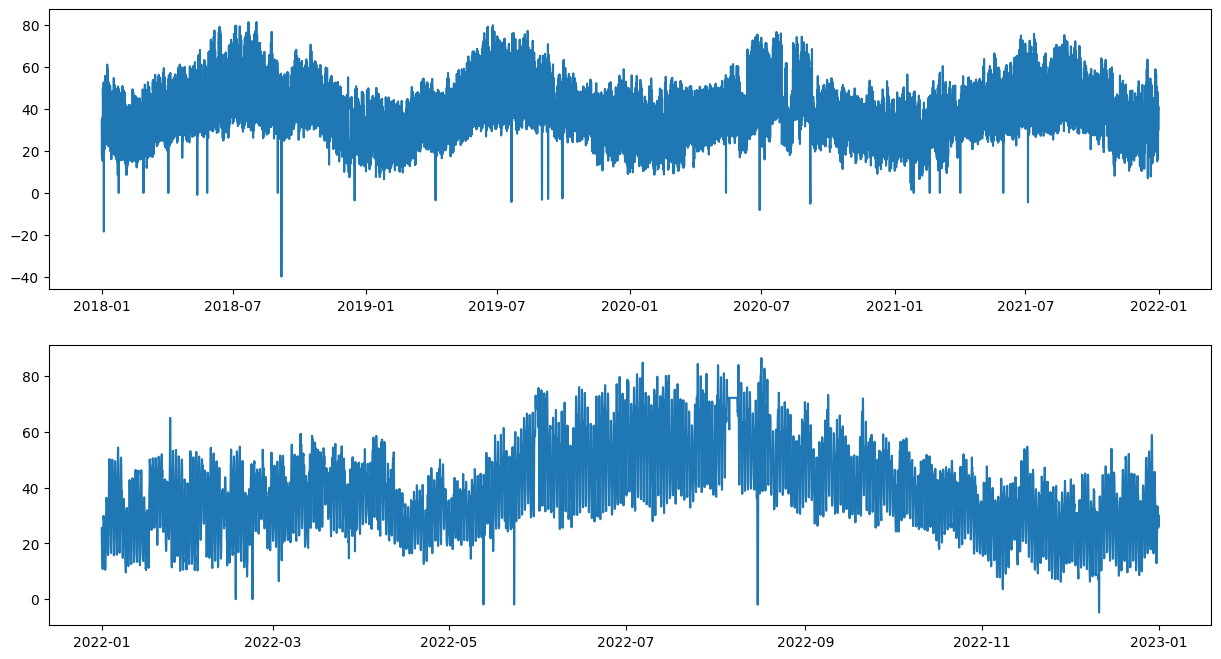

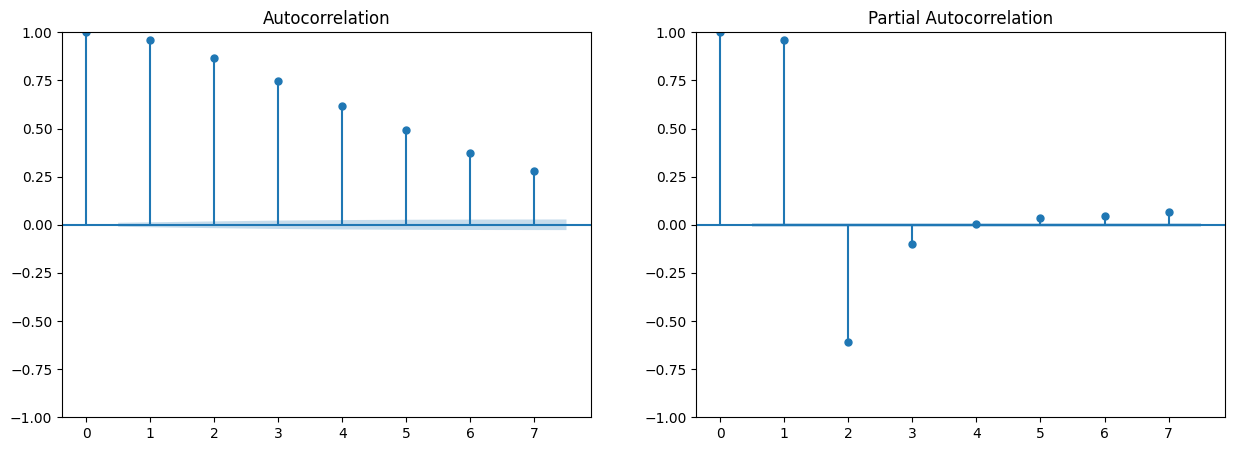

In [4]:
ym=ds_train["consumption"].to_numpy()
xm=ds_train.index.to_numpy()
ytm=ds_test["consumption"].to_numpy()
xtm=ds_test.index.to_numpy()
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym);
axes[1].plot(xtm,ytm);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym,lags=7,ax=axes[0]);
plot_pacf(ym,lags=7,method="ywm",ax=axes[1]);


Revisión de Datos Faltantes

In [5]:
deltas = 365*24*4
#agregamos un día al rango por el año bisiesto 2020
deltas+=24
start = datetime.datetime.strptime("2018-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
train_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
deltas = 365*24
start = datetime.datetime.strptime("2022-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
test_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
missing_train=[]
for fecha in train_full:
    if not (fecha in ds_train.index):
        missing_train.append(fecha)
missing_test=[]
for fecha in test_full:
    if not (fecha in ds_test.index): 
        missing_test.append(fecha)
print(len(train_full),len(ds_train),len(missing_train))
print(len(test_full),len(ds_test),len(missing_test))
for missing in missing_test:
    print(missing.strftime('%Y-%m-%d %H:%M:%S')) 

35064 35064 0
8760 8760 0


In [6]:
result = adfuller(ym)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.436962
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [7]:
t_media=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_media.csv",sep=";")
t_media["date"]=pd.to_datetime(t_media["date"],format="%Y-%m-%d %H:%M:%S")
t_media=t_media.set_index("date")
fin= datetime.datetime.strptime("2023-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
t_media_fin=t_media.loc[fin]
t_media=t_media.query("date.dt.year>2017 and date.dt.year<2023")
t_media.loc[fin]=t_media_fin
t_media.head()

,t_media
date,
2018-01-01,20.2
2018-01-02,21.1
2018-01-03,22.3
2018-01-04,21.9
2018-01-05,22.2


In [8]:
t_minima=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_minima.csv",sep=";")
t_minima["date"]=pd.to_datetime(t_minima["date"],format="%Y-%m-%d %H:%M:%S")
t_minima=t_minima.set_index("date")
t_minima_fin=t_minima.loc[fin]
t_minima=t_minima.query("date.dt.year>2017 and date.dt.year<2023")
t_minima.loc[fin]=t_minima_fin
t_minima.head()

,t_minima
date,
2018-01-01,12.8
2018-01-02,12.4
2018-01-03,12.1
2018-01-04,14.1
2018-01-05,15.4


In [9]:
t_maxima=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_maxima.csv",sep=";")
t_maxima["date"]=pd.to_datetime(t_maxima["date"],format="%Y-%m-%d %H:%M:%S")
t_maxima=t_maxima.set_index("date")
t_maxima_fin=t_maxima.loc[fin]
t_maxima=t_maxima.query("date.dt.year>2017 and date.dt.year<2023")
t_maxima.loc[fin]=t_maxima_fin
t_maxima.head()

,t_maxima
date,
2018-01-01,28.9
2018-01-02,30.2
2018-01-03,31.6
2018-01-04,31.7
2018-01-05,30.0


In [10]:
print(len(t_minima),len(t_media),len(t_maxima),365*5+1)

1827 1827 1827 1826


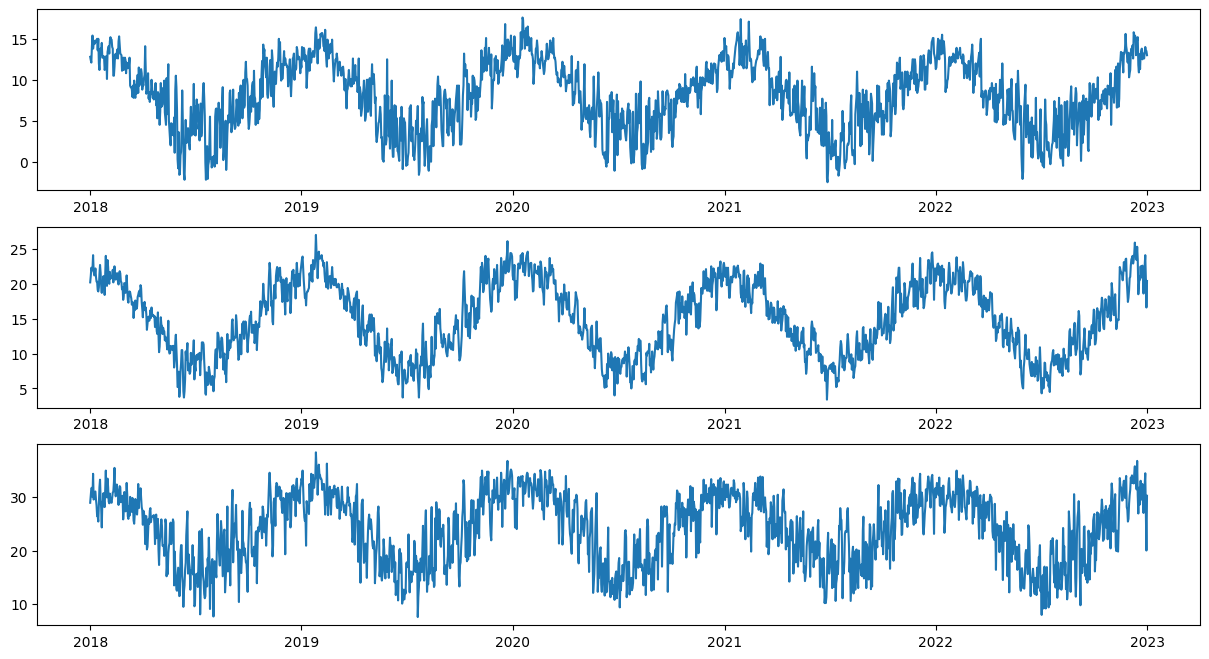

In [11]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 8)
axes[0].plot(t_minima.index,t_minima);
axes[1].plot(t_media.index,t_media);
axes[2].plot(t_maxima.index,t_maxima)

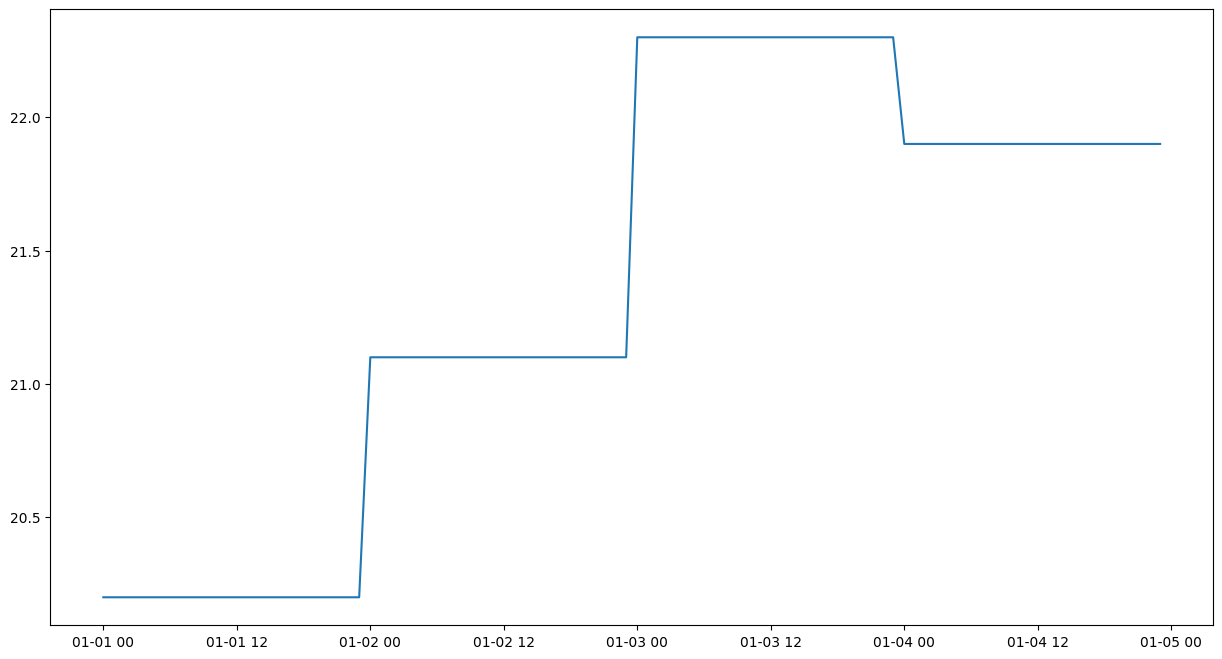

In [12]:
t_media_hora=t_media.resample("1h").ffill()
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(t_media_hora.index[:96],t_media_hora[:96]);

In [13]:
t_maxima_hora=t_maxima.resample("1h").ffill()
t_minima_hora=t_minima.resample("1h").ffill()
print(len(t_minima_hora),len(t_media_hora),len(t_maxima_hora),365*5*24+1*24)

43825 43825 43825 43824


In [14]:
t_media_train=t_media_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_media_test=t_media_hora.query("date.dt.year==2022")
t_minima_train=t_minima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_minima_test=t_minima_hora.query("date.dt.year==2022")
t_maxima_train=t_maxima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_maxima_test=t_maxima_hora.query("date.dt.year==2022")

In [20]:
ds_train=ds_train.join(t_minima_train["t_minima"])
ds_train=ds_train.join(t_media_train["t_media"])
ds_train=ds_train.join(t_maxima_train["t_maxima"])
ds_train["w"]=ds_train.index.dayofweek
ds_train["m"]=ds_train.index.month
ds_train["h"]=ds_train.index.hour
print(pearsonr(ds_train["consumption"],ds_train["t_media"]))
print(pearsonr(ds_train["consumption"],ds_train["t_minima"]))
print(pearsonr(ds_train["consumption"],ds_train["t_maxima"]))
print(pearsonr(ds_train["consumption"],ds_train["w"]))
print(pearsonr(ds_train["consumption"],ds_train["m"]))
print(pearsonr(ds_train["consumption"],ds_train["h"]))

PearsonRResult(statistic=-0.48083788888868956, pvalue=0.0)
PearsonRResult(statistic=-0.4364928885507775, pvalue=0.0)
PearsonRResult(statistic=-0.44762732525762555, pvalue=0.0)
PearsonRResult(statistic=-0.16901818798725682, pvalue=5.429055703234984e-223)
PearsonRResult(statistic=0.1265849293928329, pvalue=3.465196248245333e-125)
PearsonRResult(statistic=0.5246818887301639, pvalue=0.0)


In [21]:
ds_test=ds_test.join(t_minima_test["t_minima"])
ds_test=ds_test.join(t_media_test["t_media"])
ds_test=ds_test.join(t_maxima_test["t_maxima"])
ds_test["w"]=ds_test.index.dayofweek
ds_test["m"]=ds_test.index.month
ds_test["h"]=ds_test.index.hour
print(pearsonr(ds_test["consumption"],ds_test["t_media"]))
print(pearsonr(ds_test["consumption"],ds_test["t_minima"]))
print(pearsonr(ds_test["consumption"],ds_test["t_maxima"]))
print(pearsonr(ds_test["consumption"],ds_test["w"]))
print(pearsonr(ds_test["consumption"],ds_test["m"]))
print(pearsonr(ds_test["consumption"],ds_test["h"]))

PearsonRResult(statistic=-0.5694986997612126, pvalue=0.0)
PearsonRResult(statistic=-0.5342029994894597, pvalue=0.0)
PearsonRResult(statistic=-0.5223074129267719, pvalue=0.0)
PearsonRResult(statistic=-0.1262871138294452, pvalue=1.784645742428329e-32)
PearsonRResult(statistic=0.03290210819630109, pvalue=0.002070958740669617)
PearsonRResult(statistic=0.47756823164543905, pvalue=0.0)


In [22]:
y_train=ds_train[["consumption","t_media","w","h"]].to_numpy()
y_test=ds_test[["consumption","t_media","w","h"]].to_numpy()
print(len(y_train)+len(y_test))

43824


In [23]:
yw_train=[]
ytw_train=[]
window=216
for i in range(0,len(y_train)):
    if i+window < len(y_train):
        row=[]
        for j in range(48):
            row.append(y_train[i+j])
        yw_train.append(row)
        row=[]
        for j in range(168):
            row.append(y_train[i+48+j][0])
        ytw_train.append(row)
    else:
        break
yw_train=np.asarray(yw_train)
ytw_train=np.asarray(ytw_train)
print(yw_train.shape,ytw_train.shape)

(34848, 48, 4) (34848, 168)


In [24]:
yw_test=[]
ytw_test=[]
window=216
for i in range(0,len(y_test)):
    if i+window < len(y_test):
        row=[]
        for j in range(48):
            row.append(y_test[i+j])
        yw_test.append(row)
        row=[]
        for j in range(168):
            row.append(y_test[i+48+j][0])
        ytw_test.append(row)
    else:
        break
yw_test=np.asarray(yw_test)
ytw_test=np.asarray(ytw_test)
print(yw_test.shape,ytw_test.shape)

(8544, 48, 4) (8544, 168)


In [25]:
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import random as rd

2024-05-02 17:22:21.832494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
model = Sequential()
model.add(Input(name="serie",shape=(48,4)))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dense(168, activation='linear'))
tag="rnn_htw"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-4)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw_train, ytw_train, validation_data=(yw_test,ytw_test),
                batch_size=256, epochs=32,shuffle=True,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 479ms/step - loss: 18.3484 - mae: 18.8425 - mse: 583.2440 - val_loss: 11.5229 - val_mae: 12.0199 - val_mse: 229.0616
Epoch 2/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 67s 490ms/step - loss: 9.5714 - mae: 10.0621 - mse: 151.4957 - val_loss: 9.4945 - val_mae: 9.9766 - val_mse: 145.6105
Epoch 3/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 66s 481ms/step - loss: 8.4713 - mae: 8.9610 - mse: 119.3414 - val_loss: 7.9931 - val_mae: 8.4873 - val_mse: 113.3474
Epoch 4/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 66s 478ms/step - loss: 6.8666 - mae: 7.3520 - mse: 88.2163 - val_loss: 5.9840 - val_mae: 6.4938 - val_mse: 71.8510
Epoch 5/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 66s 483ms/step - loss: 5.4158 - mae: 5.8960 - mse: 62.7375 - val_loss: 5.4932 - val_mae: 6.0000 - val_mse: 62.0136
Epoch 6/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 66s 481ms/step - loss: 4.8193 - mae: 5.2960 - mse: 53.2829 - val_loss: 5.0344 - val_mae: 5.5366 - val_mse: 54.0748
Epoch 7/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 66s 479ms/step - lo

In [28]:
ultimo=yw_test[0].reshape(1,48,4)
ultimo.shape

(1, 48, 4)

31.84599220386905 2.773773822276161 0.08709962008780398 0.09266400703702733


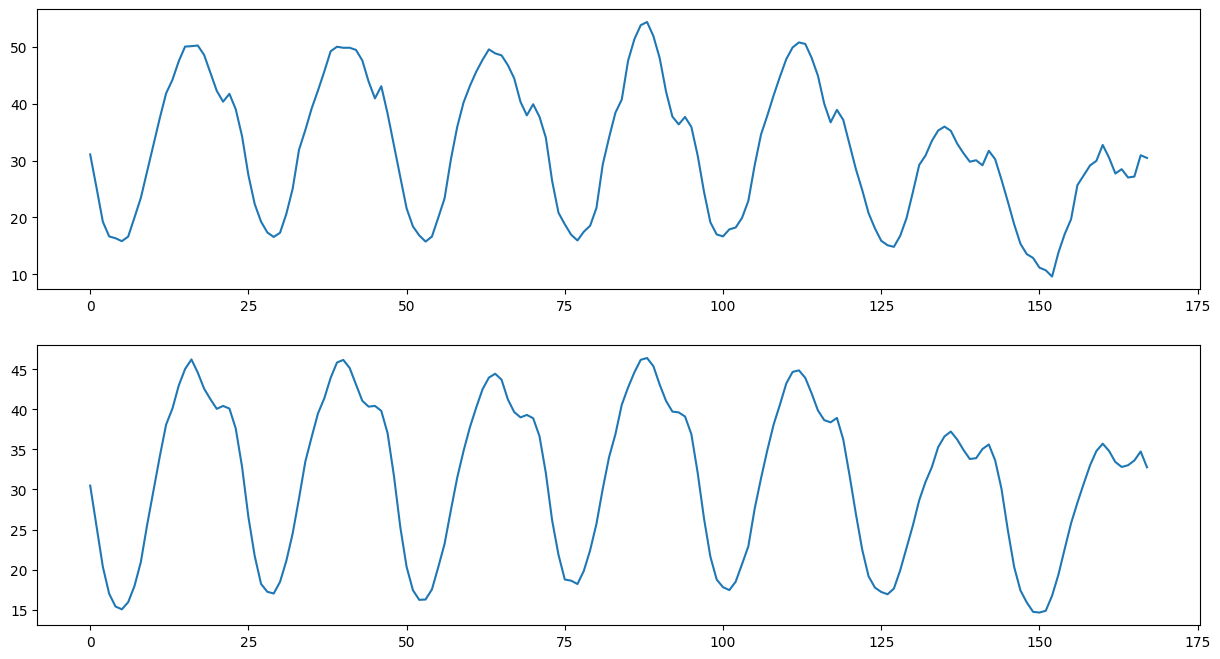

In [29]:
forecast=model.predict(ultimo,verbose=0)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
real=ytw_test[0].tolist()
pred=forecast[0].tolist()
axes[0].plot(real);
axes[1].plot(pred);
media=np.mean(real)
error=mean_absolute_error(real,pred)
error2=mean_absolute_percentage_error(real,pred)
print(media,error,error/media,error2)